# Working With Harmonised Modis Data

To ease analyses using he MODIS data, I have created a harmonised dataset stored in the [zarr](https://zarr.readthedocs.io/en/stable/getting_started.html) format. The data is stored at `/heat_center/data/remote-sensing/modis/JHB/modis.zarr`/ It _should_ be possible to operate on this data using CDO, [R](https://www.r-bloggers.com/2022/09/reading-zarr-files-with-r-package-stars/) and of course through xarray.

A seperate intake catalog for remote sensing data is available:

In [7]:
import intake
from pathlib import Path

Open the Remote Sensing Catalog

In [8]:
catalog = intake.open_catalog(Path(Path.home(),'heat_center/data/remote-sensing/intake/remote-sensing.yaml'))

So far only MODIS is available, Meteosat and Landsat will be added soon.

In [9]:
list(catalog)

['modis', 'meteosat']

We have two tiles available, one that covers Johannesburg and another for Abidjan.

In [10]:
list(catalog['modis'])

['LST', 'water_mask']

You will notice there are now two different variants of Modis LST data available for JHB and ABJ. I have named them MxD11 and MxD21. Where the x is a place holder indicating these have been created by harmonising MOD (Terra) and MYD (Aqua) data. MxD11 is the original data now referred to as Legacy by NASA, but is by far the most common in literature. MxD21 is the newer version. See [this link](https://modis-land.gsfc.nasa.gov/temp21.html#:~:text=The%20MOD11%20product%20is%20the,thus%20are%20two%20separate%20products.) for some more detail. 

In [11]:
list(catalog['modis']['LST'])

['JHB_MxD11', 'ABJ_MxD11', 'JHB_MxD21', 'ABJ_MxD21']

In [12]:
catalog['modis']['LST']['JHB_MxD21']

JHB_MxD21:
  args:
    urlpath: /home/pmarsh/heat_center/data/remote-sensing/intake/modis/LST//../../../modis/JHB/LST/MxD21A1_v061.zarr
  description: Johannesburg LST Modis Instrument
  driver: intake_xarray.xzarr.ZarrSource
  metadata:
    catalog_dir: /home/pmarsh/heat_center/data/remote-sensing/intake/modis/LST/
    tags:
    - JHB
    - remote-sensing
    - modis
    - LST
    - L3


In [13]:
%%time
ds = catalog['modis']['LST']['ABJ_MxD11'].to_dask()
ds

ERROR 1: PROJ: proj_create_from_database: Open of /share/apps/anaconda3-2022.05/envs/pangeo/share/proj failed


CPU times: user 5.51 s, sys: 2.54 s, total: 8.05 s
Wall time: 45.5 s


<xarray.Dataset>
Dimensions:      (time: 28580, lat: 1191, lon: 1209)
Coordinates:
    band         int64 ...
  * lat          (lat) float64 9.996 9.987 9.979 ... 0.01915 0.01075 0.002351
  * lon          (lon) float64 -10.15 -10.14 -10.13 ... -0.01385 -0.005456
  * time         (time) datetime64[ns] 2003-01-02T02:05:00 ... 2023-01-01T22:...
Data variables:
    LST_1km      (time, lat, lon) float64 dask.array<chunksize=(50, 100, 100), meta=np.ndarray>
    QC           (time, lat, lon) float32 dask.array<chunksize=(50, 100, 100), meta=np.ndarray>
    QC_overall   (time, lat, lon) uint8 dask.array<chunksize=(50, 100, 100), meta=np.ndarray>
    TOD          (time) <U5 dask.array<chunksize=(50,), meta=np.ndarray>
    satellite    (time) <U5 dask.array<chunksize=(50,), meta=np.ndarray>
    spatial_ref  int64 ...
    view_angl    (time, lat, lon) float64 dask.array<chunksize=(50, 100, 100), meta=np.ndarray>
    view_time    (time, lat, lon) float64 dask.array<chunksize=(50, 100, 100), meta=np.ndarray>

### Brief description of coordinates and variables:

Coordinates:
- lat/lon: This dataset has been reprojected to WGS84 such that it can be directly compared to reanalysis model data.
- time: The capture time of these tiles is not consitent, here time coresponds to the average UTC time across valid pixels in each swath.

Variables:

- LST_1km: Land Surface Temperature (at 1km resolution). This is a combination of LST_Day_1km and LST_Night_1km from Aqua and MODIS.
- QC: This is an unmodified variable from the source data. It is a bitwise representation of a number of Quality Control paramaters. See 01_Understanding_MODIS_Data.ipynb for a description and explanation on how to decode this variable.
- QC_overall: This is bit 0 of the QC variable, where a value of 0 corresponds to: 'good quality, not necessary to examine more detailed' and 1 corresponds to 'other quality, recommend examination of more detailed QA'
- TOD: either 'Day' or 'Night'. This allows easy slicing between day or night LST measurements as presumably these will be associated with different statistical models.
- satellite: either 'Aqua' or 'Terra' to allow easy slicing of the data between satellites.
- spatial_ref: Null, but contains a number of attributes used by rioxarray for reprojection purposes. 
- view_angl: The angle to the land surface from the sensor. a negative sign of the viewing angle means MODIS viewing the grid from east. The information of MODIS viewing the grid from east or west may be important in understanding the view angle effect in the temporal variations in LSTs, especially in rugged regions
- view_time: The solar time at the time of capture of each pixel. See 01_Understanding_MODIS_Data.ipynb for a description and explanation on how to decode this to UTC time. 
    

As this data has been reprojected to WGS84 and harmonised pullling out a timeseries for a point in Johannesburg is as simple as:

In [14]:
%%time

#lat_, lon_ = -26.198513, 28.029066 #JHB
lat_, lon_ = 5.383200, -4.038460 #ABJ

ds_sel = ds.sel(lat = lat_, lon = lon_, method = 'nearest')

ds_sel.LST_1km.plot.scatter()

CPU times: user 4.97 s, sys: 1.58 s, total: 6.55 s
Wall time: 6.51 s


And if we would like to only consider only day time measurements we can add:

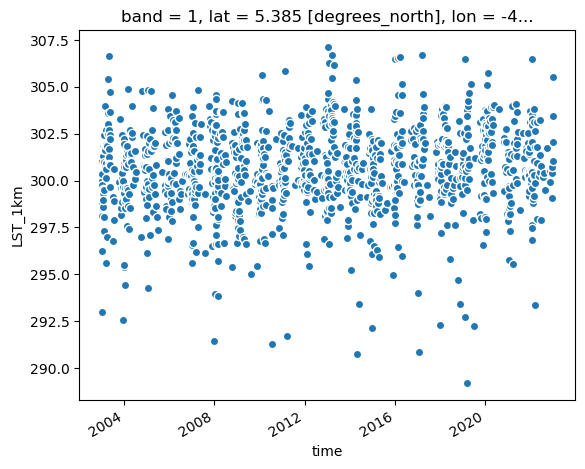

In [15]:
ds_sel = ds.sel(lat = lat_, lon = lon_,  method = 'nearest')
ds_sel_day = ds_sel.where(ds.TOD == 'Day').dropna(dim = 'time')
ds_sel_day.LST_1km.plot.scatter()

Or only data from the Terra Satellite:

In [16]:
ds_sel = ds.sel(lat = lat_, lon = lon_,  method = 'nearest')
ds_sel_day = ds_sel.where(ds.satellite == 'Terra').dropna(dim = 'time')
ds_sel_day.LST_1km.plot.scatter()

### Slicing through time

As the time steps of of this dataset do not monotonically increase some `.sel(` functions which work on our reanalysis data will not work:

In [17]:
#  ds.sel(time = slice('2020', '2022'))  #this will fail.....

I will outline a few ways to work around this here. 

1) Create a pandas DateTimeIndex and mask the resulting list as True/False

In [18]:
import pandas as pd
import numpy as np

Only a year range:

In [19]:
%%time
ds_sel_time = ds.where(ds.time[pd.DatetimeIndex(ds.time.values).year >= 2020])
ds_sel_time = ds_sel_time.where(ds_sel_time.time[pd.DatetimeIndex(ds_sel_time.time.values).year <= 2022])

CPU times: user 1.5 s, sys: 213 ms, total: 1.72 s
Wall time: 2.07 s


In [20]:
%%time
ds_sel_time.sel(lat = lat_, lon = lon_,  method = 'nearest').LST_1km.plot.scatter()

CPU times: user 2.25 s, sys: 672 ms, total: 2.92 s
Wall time: 1.28 s


Or a single month:

CPU times: user 518 ms, sys: 104 ms, total: 621 ms
Wall time: 841 ms


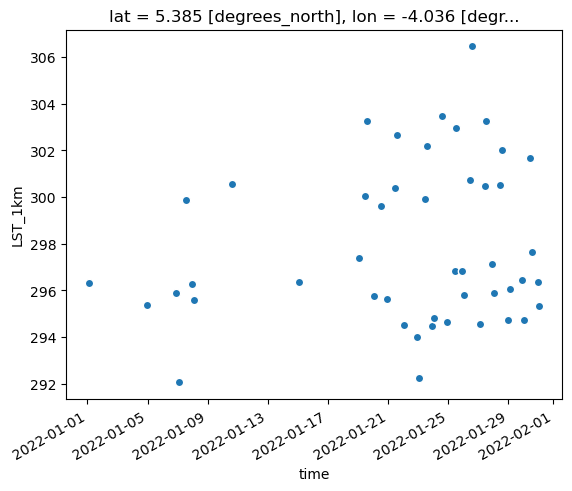

In [21]:
%%time
ds_sel_time = ds.where(ds.time[pd.DatetimeIndex(ds.time.values).year == 2022])
ds_sel_time = ds_sel_time.where(ds_sel_time.time[pd.DatetimeIndex(ds_sel_time.time.values).month == 1])

ds_sel_time.sel(lat = lat_, lon = lon_,  method = 'nearest').LST_1km.plot.scatter()

2) Use xarray's reindex function to map the data to regular 6 hour repeating time steps. This works but it adds a lot of complexity so I would avoid if possible.

In [22]:
%%time
ds = ds.sortby('time')
ds = ds.assign(original_time=(['time'],ds.time.values.astype('str')))
pandas_index = pd.DatetimeIndex(ds.time)
monotonic_index = pd.date_range(pandas_index.round('H')[0], pandas_index.round('D')[-1] + pd.Timedelta(days = 1),freq = '6h' )
ds = ds.reindex(time = monotonic_index, method='nearest', tolerance=pd.Timedelta('3h'), copy=False, fill_value = np.nan)

/share/apps/anaconda3-2022.05/envs/pangeo/lib/python3.10/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(
/share/apps/anaconda3-2022.05/envs/pangeo/lib/python3.10/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 13
  result = blockwise(
/share/apps/anaconda3-2022.05/envs/pangeo/lib/python3.10/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(
/share/apps/anaconda3-2022.05/envs/pangeo/lib/python3.10/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 13
  result = blockwise(
/share/apps/anaconda3-2022.05/envs/pangeo/lib/python3.10/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(
/share/apps/anaconda3-2022.05/envs/pangeo/lib/python3.10/site-packages/dask/array/core.py:

CPU times: user 2.7 s, sys: 540 ms, total: 3.24 s
Wall time: 3.38 s


/share/apps/anaconda3-2022.05/envs/pangeo/lib/python3.10/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(
/share/apps/anaconda3-2022.05/envs/pangeo/lib/python3.10/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 13
  result = blockwise(


CPU times: user 1.37 s, sys: 503 ms, total: 1.87 s
Wall time: 1.1 s


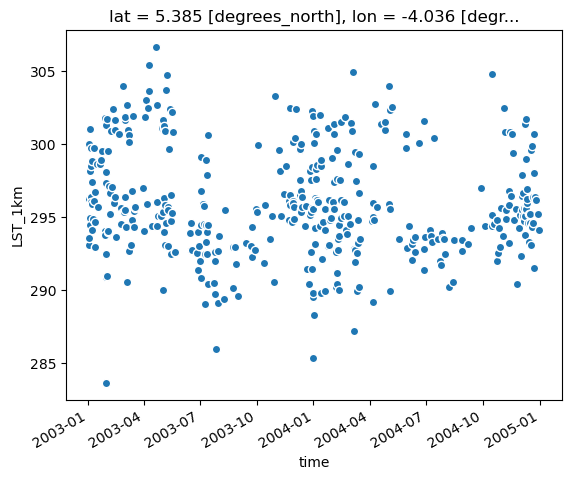

In [23]:
%%time
ds_sel_time = ds.sel(time = slice('2003-01-01', '2004-12-31'))
ds_sel_time.sel(lat = lat_, lon = lon_,  method = 'nearest').LST_1km.plot.scatter()

This second method is easier but relating the original time back to this regridded time is not straight forward....

And note how the length of the time axis has increased, as we have added null entries where no data was recorded.

In [24]:
ds

<xarray.Dataset>
Dimensions:        (lat: 1191, lon: 1209, time: 29224)
Coordinates:
  * lat            (lat) float64 9.996 9.987 9.979 ... 0.01915 0.01075 0.002351
  * lon            (lon) float64 -10.15 -10.14 -10.13 ... -0.01385 -0.005456
  * time           (time) datetime64[ns] 2003-01-02T02:00:00 ... 2023-01-02T2...
    band           int64 ...
Data variables:
    LST_1km        (time, lat, lon) float64 dask.array<chunksize=(50, 100, 100), meta=np.ndarray>
    QC             (time, lat, lon) float32 dask.array<chunksize=(50, 100, 100), meta=np.ndarray>
    QC_overall     (time, lat, lon) float64 dask.array<chunksize=(50, 100, 100), meta=np.ndarray>
    TOD            (time) object dask.array<chunksize=(50,), meta=np.ndarray>
    satellite      (time) object dask.array<chunksize=(50,), meta=np.ndarray>
    spatial_ref    int64 ...
    view_angl      (time, lat, lon) float64 dask.array<chunksize=(50, 100, 100), meta=np.ndarray>
    view_time      (time, lat, lon) float64 dask.array<chunksize=(50, 100, 100), meta=np.ndarray>
    original_time  (time) object '2003-01-02T02:05:00.000000000' nan ... nan nan

We can convert back to the original time steps by calling:

In [25]:
ds = ds.where(ds.TOD[ds.TOD.notnull()])
ds['time'] = pd.to_datetime(ds.original_time)

In [26]:
ds

<xarray.Dataset>
Dimensions:        (time: 23267, lat: 1191, lon: 1209)
Coordinates:
  * lat            (lat) float64 9.996 9.987 9.979 ... 0.01915 0.01075 0.002351
  * lon            (lon) float64 -10.15 -10.14 -10.13 ... -0.01385 -0.005456
  * time           (time) datetime64[ns] 2003-01-02T02:05:00 ... 2023-01-01T2...
    band           int64 1
Data variables:
    LST_1km        (time, lat, lon) float64 dask.array<chunksize=(41, 100, 100), meta=np.ndarray>
    QC             (time, lat, lon) float32 dask.array<chunksize=(41, 100, 100), meta=np.ndarray>
    QC_overall     (time, lat, lon) float64 dask.array<chunksize=(41, 100, 100), meta=np.ndarray>
    TOD            (time) object dask.array<chunksize=(41,), meta=np.ndarray>
    satellite      (time) object dask.array<chunksize=(41,), meta=np.ndarray>
    spatial_ref    (time) float64 dask.array<chunksize=(41,), meta=np.ndarray>
    view_angl      (time, lat, lon) float64 dask.array<chunksize=(41, 100, 100), meta=np.ndarray>
    view_time      (time, lat, lon) float64 dask.array<chunksize=(41, 100, 100), meta=np.ndarray>
    original_time  (time) object dask.array<chunksize=(41,), meta=np.ndarray>

# Comparing MODIS LST to ERA5 air temperature

Let's start by clipping the Modis data to a square over the JHB municipality.

In [33]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

shpfile = gpd.read_file(Path(Path.home(),'heat_center/data/gis/RP2/JHB/vector/openAFRICA/JHB/metropolitan municipality jhb.shp'))
lonmin,latmin,lonmax,latmax = shpfile.iloc[0].geometry.bounds

ds = catalog['modis']['LST']['JHB_MxD11'].to_dask()
ds = ds.sel(lat = slice(latmax, latmin), lon = slice(lonmin, lonmax))

ds = ds.drop('band')

Now Let's do the same with ERA5-Land data. And also clip it to a rough time range.

In [34]:
catalog_reanalysis = intake.open_catalog(Path(Path.home(),'heat_center/data/climate/reanalysis/intake/reanalysis.yaml'))

ds_ERA5 = catalog_reanalysis['ERA5-Land']['1hr']['tas'].to_dask()

ds_ERA5 = ds_ERA5.sel(time = slice('2003', '2021')).tas

ds_ERA5 = ds_ERA5.rename({'latitude':'lat', 'longitude':'lon'})
ds_ERA5 = ds_ERA5.sel(lat = slice(latmax+1, latmin-1), lon = slice(lonmin-1, lonmax+1))

And Modis to the same date range:

In [35]:
ds = ds.where(ds.time[pd.DatetimeIndex(ds.time.values).year >= 2003])
ds = ds.where(ds.time[pd.DatetimeIndex(ds.time.values).year <= 2021])

To simplify this first attempt let's exclude MODIS data with any NAN (cloudy) pixels.

In [36]:
len(ds.time) # just to guage how many time steps we are dropping = a lot!

27592

In [37]:
ds = ds['LST_1km'].dropna(dim = 'time', how = 'any')
len(ds.time)

5317

Now let's resample ERA5 to only include timestepvalues corresponding to valid MODIS steps.

First round all MODIS time's to the nearest hour.

In [38]:
ds = ds.sortby('time')
rounded_time = pd.DatetimeIndex(ds.time).round('H')
ds = ds.reindex(time = rounded_time, method='nearest', tolerance=pd.Timedelta('1h'), copy=False, fill_value = np.nan)

and subselect from ERA5

In [39]:
common_times = [t for t in ds_ERA5.time.values if t in ds.time.values]
ds_ERA5 = ds_ERA5.sel(time = common_times)

Now Let's regrid ERA5 to the same grid as MODIS

In [40]:
ds_ERA5 = ds_ERA5.interp(lat = ds.lat.values, lon = ds.lon.values, method = 'linear')

In [41]:
%%time
#ds = ds.stack(space = ('lat','lon'))
ds = (ds - ds.min()) / (ds.max() - ds.min())
ds = ds.load()

CPU times: user 13.1 s, sys: 3.58 s, total: 16.7 s
Wall time: 11.9 s


In [42]:
%%time
#ds_ERA5 = ds_ERA5.stack(space = ('lat','lon'))
ds_ERA5 = (ds_ERA5 - ds_ERA5.min()) / (ds_ERA5.max() - ds_ERA5.min())
ds_ERA5 = ds_ERA5.load()

CPU times: user 58.6 s, sys: 17.4 s, total: 1min 15s
Wall time: 2min 57s


Some scatter plots to compare this data:

All points:

Text(0, 0.5, 'Modis Land Surface Temperature')

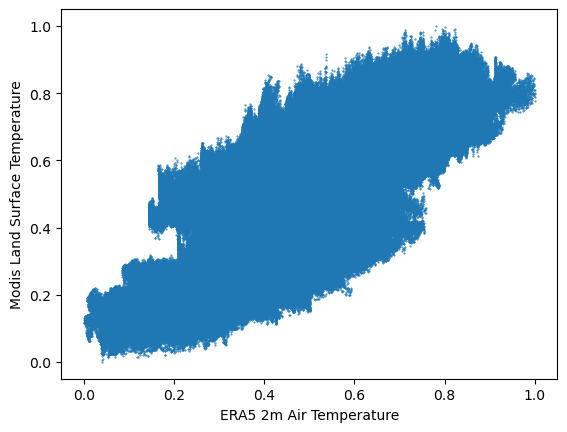

In [43]:
import matplotlib.pyplot as plt

plt.scatter(x = ds_ERA5.values, y = ds.values, s = 0.2)
plt.xlabel('ERA5 2m Air Temperature')
plt.ylabel('Modis Land Surface Temperature')

At a single location:

Text(0, 0.5, 'Modis Land Surface Temperature')

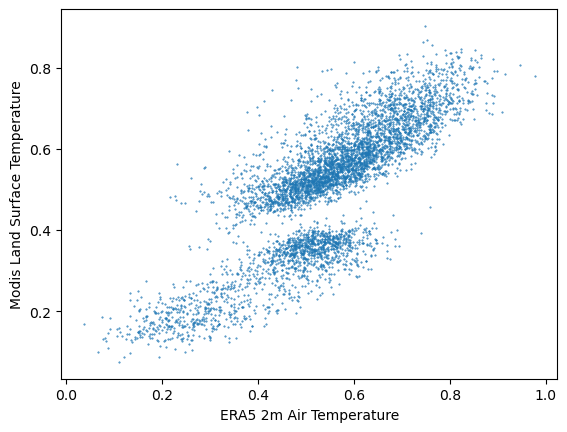

In [44]:
plt.scatter(x = ds_ERA5.sel(lat = lat_, lon = lon_,  method = 'nearest').values, y = ds.sel(lat = lat_, lon = lon_,  method = 'nearest').values, s = 0.2)
plt.xlabel('ERA5 2m Air Temperature')
plt.ylabel('Modis Land Surface Temperature')

There appears to be two distinct clusterings, presumably day vs night

In [45]:
#client.close()